In [ ]:
!pip install -U dm-haiku optax

# For scientific computing/randomness/jax functionality.
import jax
import jax.numpy as jnp
import jax.random as random 
import jax.nn as nn

# For neural networks
import haiku as hk

# For optimizers
import optax

import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# First let's generate some data and plot some time series
# def create_fake_data(time_series_length, dimensionality):
time_series_length = 100
dimensionality = 6
rng = hk.PRNGSequence(0)

# A Single time series will have shape (T, D)

def create_period_changing_single(phase, time_series_length, dimensionality):
    x = jnp.arange(0.0, 1.0, 1.0/ time_series_length)
    data = jnp.vstack([jnp.sin(x * (1 + n) * 2.0 * jnp.pi + phase) for n in range(dimensionality)]).T
    return data

create_period_changing_data_ = jax.vmap(create_period_changing_single, in_axes=(0, None, None))

# Create batch version
def create_period_changing_data(n):
    phases = random.uniform(next(rng), shape=(n,)) * 2 * jnp.pi
    return create_period_changing_data_(phases, time_series_length, dimensionality)

batch_size = 32
data = create_period_changing_data(batch_size)
print(data.shape)


(32, 100, 6)


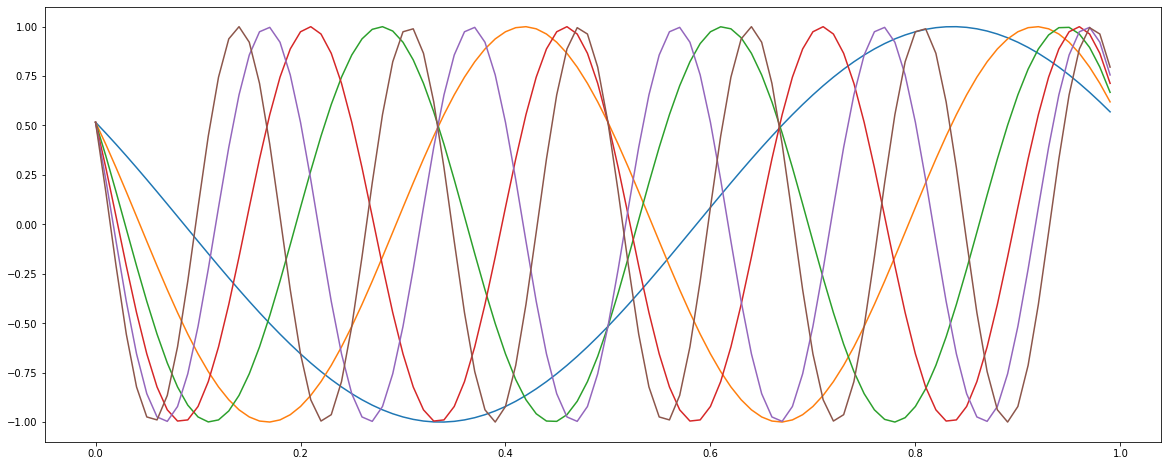

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(jnp.arange(0, 1, 1/time_series_length), data[1])
plt.show()

In [ ]:
class TimeSeriesAE(hk.Module):

    def __init__(self):
        super().__init__()
        # Setup the VAE

        # Encoder Components
        self.conv1 = hk.Conv1D(16, 8, 3)
        self.conv2 = hk.Conv1D(8, 4, 2)
        self.fc1 = hk.Linear(2)

        # Decoder components
        self.fc2 = hk.Linear(16 * 16)
        self.deconv1 = hk.Conv1DTranspose(16, 4, 2)
        self.deconv2 = hk.Conv1DTranspose(32, 7, 3, padding="VALID")
        self.deconv3 = hk.Conv1DTranspose(6, 2)


    def encode(self, x):
        z = nn.relu(self.conv1(x))
        z = nn.relu(self.conv2(z))
        # Flatten z
        z = jnp.reshape(z, (z.shape[0], -1))
        # Final encoding to 2 dimensional
        z = self.fc1(z)

        return z

    def decode(self, z):
        # We expect z to be of shape (N, 2)
        z = nn.relu(self.fc2(z)) # (N, 16 * 16)
        x = jnp.reshape(z, (z.shape[0], 16, 16)) # (N, 16, 16)
        x = nn.relu(self.deconv1(x))
        x = nn.relu(self.deconv2(x))
        x = self.deconv3(x)
        return x

        # We need to map to something (N, T, D)
        

#####
def time_series_ae_():

    model = TimeSeriesAE()

    def init(x):

        z = model.encode(x)
        x = model.decode(z)

    return init, (model.encode, model.decode)

time_series_ae = hk.without_apply_rng(hk.multi_transform(time_series_ae_))
params = time_series_ae.init(next(rng), data)
encode, decode = time_series_ae.apply
#######

In [ ]:
@jax.jit
def loss_(params, data_target):
    data_reconstructed = decode(params, encode(params, data_target))
    return jnp.mean(jnp.sum((data_target - data_reconstructed) ** 2, axis=(1, 2)))

# Declare optimizer
optimiser = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(0.01, b1=0.9, b2=0.99),
)
opt_state = optimiser.init(params)

Epoch 20, Avg. Loss: 223.6475830078125
Epoch 40, Avg. Loss: 69.94554138183594
Epoch 60, Avg. Loss: 21.272998809814453
Epoch 80, Avg. Loss: 10.548505783081055
Epoch 100, Avg. Loss: 7.010871887207031
Epoch 120, Avg. Loss: 5.435048580169678
Epoch 140, Avg. Loss: 4.508470058441162
Epoch 160, Avg. Loss: 3.696335554122925
Epoch 180, Avg. Loss: 3.270045042037964
Epoch 200, Avg. Loss: 3.498997449874878
Epoch 220, Avg. Loss: 2.8634419441223145
Epoch 240, Avg. Loss: 2.474907159805298
Epoch 260, Avg. Loss: 2.0844428539276123
Epoch 280, Avg. Loss: 2.3712210655212402
Epoch 300, Avg. Loss: 2.3299973011016846
Epoch 320, Avg. Loss: 3.3622279167175293
Epoch 340, Avg. Loss: 2.7637479305267334
Epoch 360, Avg. Loss: 2.4216277599334717
Epoch 380, Avg. Loss: 1.9708036184310913
Epoch 400, Avg. Loss: 1.963693380355835
Epoch 420, Avg. Loss: 2.0128390789031982
Epoch 440, Avg. Loss: 1.8377984762191772
Epoch 460, Avg. Loss: 2.0336766242980957
Epoch 480, Avg. Loss: 2.0643277168273926
Epoch 500, Avg. Loss: 1.804442

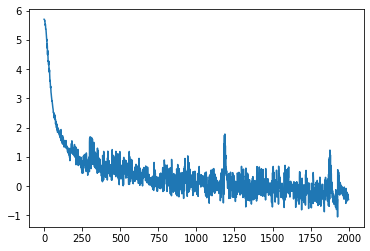

In [ ]:
n_epochs = 2000
log_every_ep = 20
losses = []
for epoch in range(n_epochs):
    # Generate a random batch of data of shape (N, T, D)
    batch = create_period_changing_data(batch_size)
    
    # Compute a loss and a gradient per batch
    loss, grad = jax.value_and_grad(loss_)(params, batch)
    # Saving the loss
    losses.append(loss)
    # Updating the parameters
    updates, opt_state = optimiser.update(grad, opt_state)
    params = optax.apply_updates(params, updates)

    if epoch % log_every_ep == log_every_ep - 1:
        print(f"Epoch {epoch + 1}, Avg. Loss: {sum(losses[-log_every_ep:]) / log_every_ep}")

plt.plot(jnp.log(jnp.array(losses)))

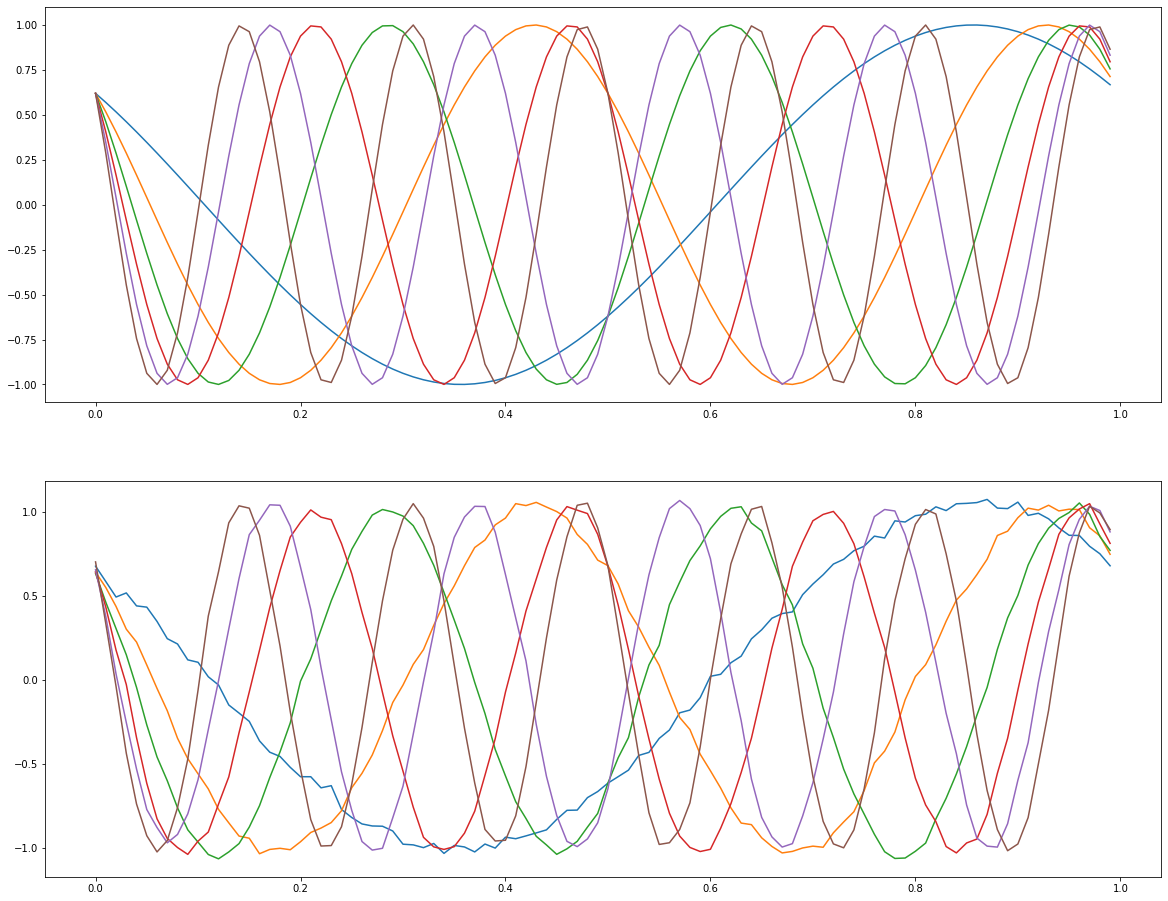

In [ ]:
fake_data = create_period_changing_data(10)
fake_data_reconstructed = decode(params, encode(params, fake_data))

idx = 0
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 16))
ax1.plot(jnp.arange(0, 1, 1/time_series_length), fake_data[idx])
ax2.plot(jnp.arange(0, 1, 1/time_series_length), fake_data_reconstructed[idx])
plt.show()

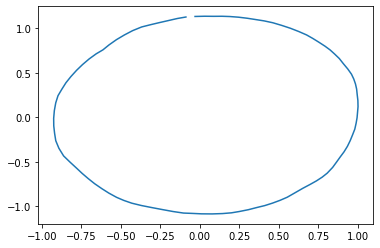

In [ ]:
phases = jnp.arange(0, 1.0, .01) * 2 * jnp.pi
data_to_encode = create_period_changing_data_(phases, time_series_length, dimensionality) 
encoded_data = encode(params, data_to_encode)
plt.plot(encoded_data[:,0], encoded_data[:,1])